In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np

import darkhistory.physics as phys

import main_dm_baryon_scattering as main

from tqdm import tqdm_notebook as tqdm

import pickle

In [87]:
%autoreload
import config
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

f_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def xsec_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def xsec_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]

In [5]:
struct_boost = phys.struct_boost_func(model='einasto_subs')
struct_boost_NFW = phys.struct_boost_func(model='NFW_no_subs')
struct_boost_pwave = phys.struct_boost_func(model='pwave_NFW_no_subs')

# Improved f_exc

In [6]:
mDM=1e6
lifetime=3e25
sigmav=3e-26
datums = main.evolve(
    DM_process='decay', mDM=mDM, primary='phot_delta',
    start_rs = 3000, sigmav=sigmav, lifetime=lifetime,
    coarsen_factor=4, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.01
)
eleceng = datums['lowengelec'].eng

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


In [17]:
import darkhistory.low_energy.lowE_electrons as lowE_elec
import darkhistory.low_energy.lowE_photons as lowE_phot
import darkhistory.low_energy.lowE_deposition as lowE
MEDEA_interp = lowE_elec.make_interpolator()

In [18]:
rs_list = datums['rs']
eleceng = datums['lowengelec'].eng
# elec_exc = [lowE_elec.compute_fs(MEDEA_interp, 
#            datums['lowengelec'][i], 
#            datums['x'][i,0], 
#            phys.inj_rate('pwave', rs_list[i], mDM=1e8, sigmav=3e-24), 
#            4*.001/phys.hubble(rs_list[i]))[2]
#  for i in np.arange(len(rs_list))]

phot_exc = [lowE_phot.compute_fs( 
           datums['lowengphot'][i],
           np.array([
                1. - phys.xHII_std(rs_list[i]),
                phys.chi - phys.xHeII_std(rs_list[i]),
                phys.xHeII_std(rs_list[i])
            ]), 
           phys.inj_rate('decay', rs_list[i], mDM=mDM, sigmav=sigmav, lifetime=lifetime), 
           4*.001/phys.hubble(rs_list[i]), method='old')[2]
 for i in np.arange(len(rs_list))]

# tot_exc = [lowE.compute_fs(MEDEA_interp, 
#            datums['lowengelec'][i], 
#            datums['lowengphot'][i], 
#            np.array([
#                 1. - phys.xHII_std(rs_list[i]),
#                 phys.chi - phys.xHeII_std(rs_list[i]),
#                 phys.xHeII_std(rs_list[i])
#             ]), 
#            phys.inj_rate('pwave', rs_list[i], mDM=1e9, sigmav=3e-24), 
#            4*.001/phys.hubble(rs_list[i]), 
#            [0,0,0,0,0], cmbloss=0, 
#            method='no_He', 
#            separate_higheng=True, 
#            cross_check=False)[0][2]
# for i in np.arange(len(rs_list))]

# tot_exc = [lowE.compute_fs(MEDEA_interp, 
#            datums['lowengelec'][i], 
#            datums['x'][i,0], 
#            phys.inj_rate('pwave', rs_list[i], mDM=1e8, sigmav=3e-24), 
#            4*.001/phys.hubble(rs_list[i]))[2]
#  for i in np.arange(len(rs_list))]

In [19]:
fexc = datums['f']['low']['exc']+0*datums['f']['high']['exc']
rs_list = datums['lowengphot'].rs
nrms = phys.nB * rs_list**3 / (4*.001/phys.hubble(rs_list)) /(
    phys.inj_rate('decay', rs_list, mDM=mDM, sigmav=sigmav, lifetime=lifetime)
)
fexc2 = datums['lowengphot'].toteng(bound_type='eng',
                            bound_arr=np.array([phys.lya_eng,phys.rydberg])
                           )*nrms

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


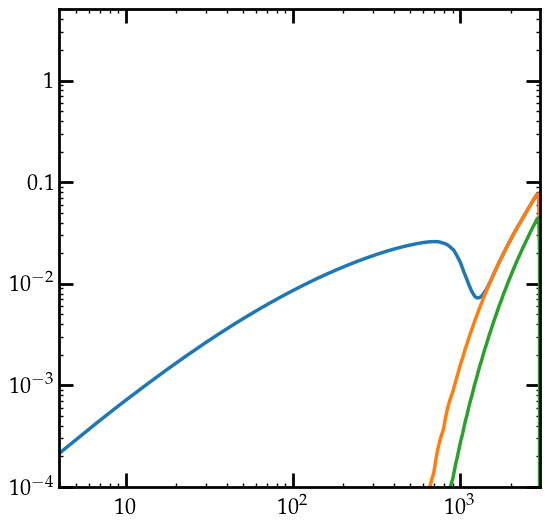

In [20]:
plt.figure()
ax = plt.gca()
plt.axis([4,3e3,1e-4,5])
ax.loglog()
plt.plot(rs_list,fexc)
plt.plot(rs_list,fexc2[0])
# plt.plot(rs_list,phys.f_std(1e9,rs_list,'phot','pwave',True,'exc'))
# plt.plot(rs_list,fexc2[0]+elec_exc)
# plt.plot(rs_list,tot_exc)
plt.plot(rs_list,phot_exc)

# Improved lowengelec

# Ionization: Total

In [7]:
import csv
HI_ionization_data = []
with open('/Users/gregoryridgway/Desktop/HI_ionization.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        HI_ionization_data.append([float(row[0]),float(row[1])])
HI_ionization_data = np.array(HI_ionization_data)

HeI_ionization_data = []
with open('/Users/gregoryridgway/Desktop/HeI_ionization.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        HeI_ionization_data.append([float(row[0]),float(row[1])])
HeI_ionization_data = np.array(HeI_ionization_data)

HeII_ionization_data = []
with open('/Users/gregoryridgway/Desktop/HeII_ionization.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        HeII_ionization_data.append([float(row[0]),float(row[1])])
HeII_ionization_data = np.array(HeII_ionization_data)

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


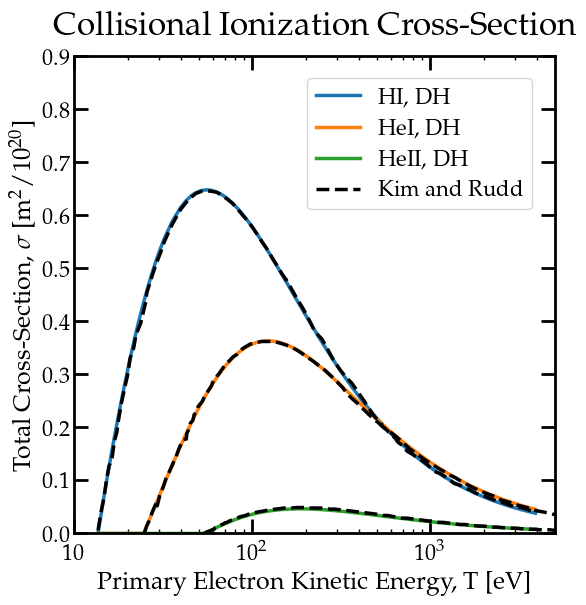

In [8]:
%autoreload
plt.figure()
plt.xscale('log')
plt.axis([10,5e3,0,.9])
eleceng = HI_ionization_data[:,0]

plt_HI, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HI', method='MEDEA')*1e16, label = r'HI, DH')

plt_HeI, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HeI', method='MEDEA')*1e16, label = r'HeI, DH')
plt_HeII, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HeII', method='MEDEA')*1e16, label = r'HeII, DH')

plt_KimHI, = plt.plot(HI_ionization_data[:,0],HI_ionization_data[:,1], linestyle='--', color='k', label=r'Kim and Rudd')
plt_KimHeI, = plt.plot(HeI_ionization_data[:,0],HeI_ionization_data[:,1], linestyle='--', color='k', label=r'HeI, Kim and Rudd')
plt_KimHeII, = plt.plot(HeII_ionization_data[:,0],HeII_ionization_data[:,1], linestyle='--', color='k', label=r'HeII, Kim and Rudd')



plt.title(r'Collisional Ionization Cross-Section')
plt.xlabel(r'Primary Electron Kinetic Energy, T [eV]')
plt.ylabel(r'Total Cross-Section, $\sigma$ [m$^2/10^{20}$]')

plt.legend(handles = [plt_HI, plt_HeI, plt_HeII, plt_KimHI])

# Ionization: Differential

In [9]:
tmpelec = np.arange(.00001,1e3,.01)

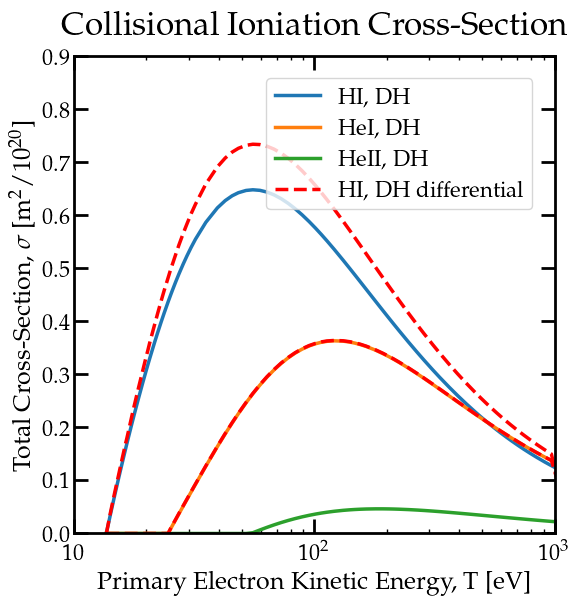

In [10]:
%autoreload
plt.figure()
plt.xscale('log')
plt.axis([10,1e3,0,.9])
eleceng = HI_ionization_data[:,0]

plt_HI, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HI', method='MEDEA')*1e16, label = r'HI, DH')

plt_HeI, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HeI', method='MEDEA')*1e16, label = r'HeI, DH')
plt_HeII, = plt.plot(eleceng, 
         phys.coll_ion_xsec(eleceng, species='HeII', method='MEDEA')*1e16, label = r'HeII, DH')


tmpdataH = np.array([
    sum(phys.coll_ion_sec_elec_spec(el, tmpelec, species='HI', method='MEDEA'))*1e16/2
    for el in eleceng
])

plt_HI_diff, = plt.plot(
    eleceng, tmpdataH, color='red', linestyle='--', label = r'DH integrated $d\sigma/dE$'
)

tmpdataHe = np.array([
    sum(phys.coll_ion_sec_elec_spec(el, tmpelec, species='HeI', method='MEDEA'))*1e16/2
    for el in eleceng
])

plt_HeI_diff, = plt.plot(
    eleceng, tmpdataHe, color='red', linestyle='--'
)

# tmpdata = np.array([
#     sum(phys.coll_ion_sec_elec_spec(el, tmpelec, species='HeII', method='MEDEA'))*1e16/2
#     for el in eleceng
# ])

# plt_HeII_diff, = plt.plot(
#     eleceng, tmpdata, color='red', linestyle='--'
# )


plt.title(r'Collisional Ioniation Cross-Section')
plt.xlabel(r'Primary Electron Kinetic Energy, T [eV]')
plt.ylabel(r'Total Cross-Section, $\sigma$ [m$^2/10^{20}$]')

plt.legend(handles = [plt_HI, plt_HeI, plt_HeII, plt_HI_diff])

# Excitation

In [11]:
H_exc_data=np.resize(
    np.loadtxt('/Users/gregoryridgway/Desktop/Hydrogen_excitation_np.txt'),
    (10,58))

H_exc_data = np.transpose(np.append(np.array([np.zeros(10)]),np.transpose(H_exc_data),axis=0))
H_exc_data[0,0] = phys.lya_eng

In [12]:
H_exc_data2 = {
    'eng_p': H_exc_data[0],
    '2p': H_exc_data[1],
    '3p': H_exc_data[2],
    '4p': H_exc_data[3],
    '5p': H_exc_data[4],
    '6p': H_exc_data[5],
    '7p': H_exc_data[6],
    '8p': H_exc_data[7],
    '9p': H_exc_data[8],
    '10p': H_exc_data[9],
    'eng_s': np.array([phys.lya_eng, 25,30.6,54,100,136,200,300,400,680]),
    '2s': np.array(
        [0, 0.076, 0.057, 0.042, 0.036, 0.031, 0.024, 0.018, 0.0135, 0.0085]
    )*np.pi*phys.bohr_rad**2*1e16
}

In [49]:
pickle.dump(H_exc_data2,open('/Users/gregoryridgway/Downloads/dataverse_files_06_08_2019/H_exc_xsec_data.p','wb'))

In [10]:
He_exc_data=np.resize(
    np.loadtxt('/Users/gregoryridgway/Desktop/He_excitation_np.txt'),
    (10,43))

He_exc_data = np.transpose(np.append(np.array([np.zeros(10)]),np.transpose(He_exc_data),axis=0))
He_exc_data[0,0] = phys.He_exc_eng['21p']

In [33]:
He_exc_data2 = {
    'eng_p': He_exc_data[0],
    '2p': He_exc_data[1],
    '3p': He_exc_data[2],
    '4p': He_exc_data[3],
    '5p': He_exc_data[4],
    '6p': He_exc_data[5],
    '7p': He_exc_data[6],
    '8p': He_exc_data[7],
    '9p': He_exc_data[8],
    '10p': He_exc_data[9],
    'eng_s': None,
    '2s': None
}

In [34]:
pickle.dump(He_exc_data2,open('/Users/gregoryridgway/Downloads/dataverse_files_06_08_2019/He_exc_xsec_data.p','wb'))

In [13]:
import csv
Kim_exc_data = []
with open('/Users/gregoryridgway/Desktop/exc_2p.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        Kim_exc_data.append([float(row[0]),float(row[1])])
Kim_exc_data = np.array(Kim_exc_data)

In [42]:
%autoreload
import config

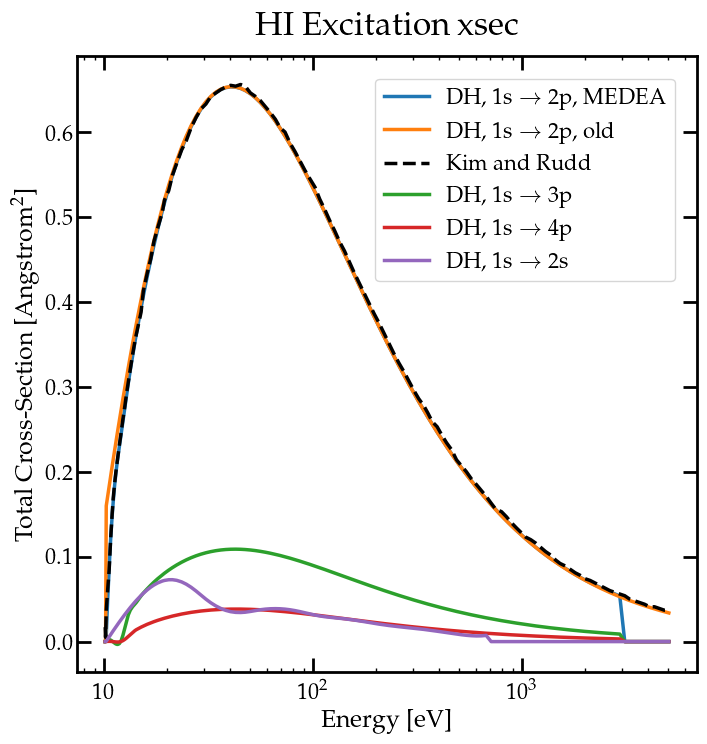

In [14]:
%autoreload
plt.figure(figsize=(8,8))
plt.xscale('log')
# plt.axis([10,3000,0,.1])
plt.title(r'HI Excitation xsec')
plt.xlabel(r'Energy [eV]')
plt.ylabel(r'Total Cross-Section [Angstrom$^2$]')
# plt.axis([10,1e5,0,.8])
eng = Kim_exc_data[:,0]
plt.plot(eng,phys.coll_exc_xsec(eng, species='HI', method = 'MEDEA',state='2p')*1e16,label=r'DH, 1s $\to$ 2p, MEDEA')
plt.plot(eng,phys.coll_exc_xsec(eng, species='HI', method = 'old')*1e16,label=r'DH, 1s $\to$ 2p, old')
plt.plot(eng,Kim_exc_data[:,1],linestyle='--',color='k', label=r'Kim and Rudd')
plt.plot(eng,phys.coll_exc_xsec(eng, species='HI', method = 'MEDEA',state='3p')*1e16,label=r'DH, 1s $\to$ 3p')
plt.plot(eng,phys.coll_exc_xsec(eng, species='HI', method = 'MEDEA',state='4p')*1e16,label=r'DH, 1s $\to$ 4p')
plt.plot(eng,phys.coll_exc_xsec(eng, species='HI', method = 'MEDEA',state='2s')*1e16,label=r'DH, 1s $\to$ 2s')

plt.legend()

# Distortions

In [15]:
import main

In [88]:
xsec_bound_phot_CMB(mDM,'swave')

4.860917376800768e-24

In [102]:
%autoreload
mDM=5e3
lifetime = 3e25
sigmav = xsec_bound_phot_CMB(mDM,'swave')
species = 'phot'
DM_process = 'swave'

data5e3 = main.evolve(
    DM_process=DM_process, mDM=mDM, lifetime=lifetime, sigmav=sigmav, 
    primary=species+'_delta',
    start_rs = 3000.,
    coarsen_factor=4, backreaction=False,
    struct_boost=struct_boost,
    end_rs=4.004
)

In [103]:
lowengphot5e3 = data5e3['lowengphot']
eng = lowengphot.eng
rs_list = lowengphot.rs

In [105]:
def norm_fac(rs,mDM):
    # Normalization to convert from per injection event to 
    # per baryon per dlnz step.
    if DM_process == 'decay':
        Einj = mDM
    else:
        Einj = 2*mDM
    return (phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=lifetime, sigmav=xsec_bound_phot_CMB(mDM,'swave')) / Einj) * (
        .001 * 4 / phys.hubble(rs) / (phys.nB * rs**3)
    )

In [ ]:
def get_distortion(spec):


In [28]:
lowengphot = lowengphot/norm_fac(rs_list, mDM)
lowengphot.redshift(np.ones_like(rs_list))
distortion_spec = lowengphot.sum_specs()
distortion_spec.switch_spec_type()

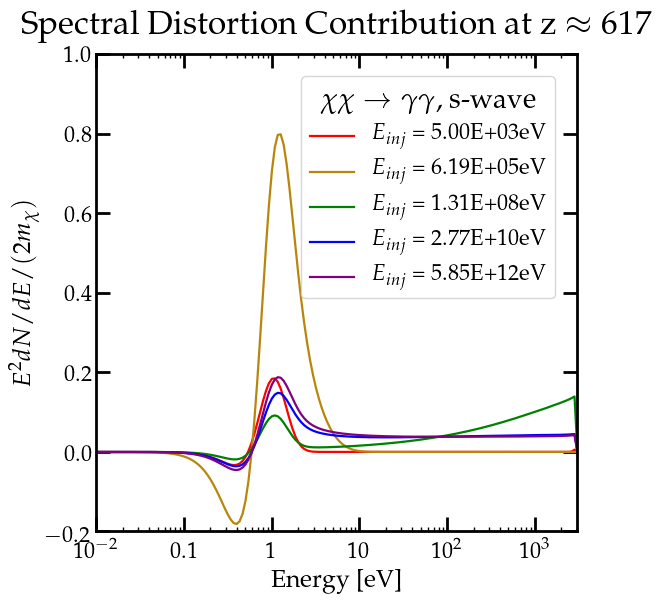

In [106]:
plt.figure()
ax = plt.gca()
# ax.loglog()
plt.xscale('log')
linewidth=1.6

plt.plot(
    eng, 
    eng**2 * lowengphot5e3[395].dNdE/(2*5e3)/norm_fac(rs_list[395],5e3),
    linewidth=linewidth,
    color='red',
    label = r'$E_{inj}$ = 5.00E+03eV'
)
plt.plot(
    eng, 
    eng**2 * lowengphot6e5[395].dNdE/(2*6.19e5)/norm_fac(rs_list[395],6.19e5),
    linewidth=linewidth,
    color='darkgoldenrod',
    label = r'$E_{inj}$ = 6.19E+05eV'
)
plt.plot(
    eng, 
    eng**2 * lowengphot1e8[395].dNdE/(2*1.31e8)/norm_fac(rs_list[395],1.31e8),
    linewidth=linewidth,
    color='green',
    label = r'$E_{inj}$ = 1.31E+08eV'
)
plt.plot(
    eng, 
    eng**2 * lowengphot3e10[395].dNdE/(2*2.77e10)/norm_fac(rs_list[395],2.77e10),
    linewidth=linewidth,
    color='blue',
    label = r'$E_{inj}$ = 2.77E+10eV'
)
plt.plot(
    eng, 
    eng**2 * lowengphot6e12[395].dNdE/(2*5.85e12)/norm_fac(rs_list[395],5.85e12),
    linewidth=linewidth,
    color='purple',
    label = r'$E_{inj}$ = 5.85E+12eV'
)


# plt.plot(eng, eng**2 * distortion_spec5e3.dNdE/(2*5e3))
plt.axis([1e-2,3e3,-2e-1,1])
plt.ylabel(r'$E^2 dN/dE / (2 m_\chi)$')
plt.xlabel('Energy [eV]')
leg = plt.legend()
leg.set_title(r'$\chi\chi \to \gamma\gamma$, s-wave')
plt.title(r'Spectral Distortion Contribution at z $\approx$ 617')
# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/PRD_v1/Ref_Response/spec_distortion_comparison_Tracy2015_partI.pdf')
plt.show()